In [119]:
import numpy as np
import pylab as plt
import skfmm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy import interpolate
import scipy
from scipy import ndimage
import time
import json
import cv2
import requests

In [42]:
def plot_surface(surface):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, surface, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [43]:
def transform(distance):
    for i in range(distance.shape[0]):
        for j in range(distance.shape[1]):
            if type(distance[i, j]) is np.ma.core.MaskedConstant:
                distance[i, j] = 1000
    return distance

In [167]:
n = 100
l = 20

X, Y = np.meshgrid(np.linspace(-l/2, l/2, n), np.linspace(-l/2, l/2, n))
phi = np.ones((n, n))
phi[np.logical_and(X==-10, Y==-10)] = 0

mask = np.less_equal(np.sqrt(X**2 + Y**2), 5)
#mask = np.logical_and(abs(X) < 6, abs(Y) < 3)
phi = np.ma.MaskedArray(phi, mask)
distance = skfmm.distance(phi)
distance = distance.T
#distance = transform(distance)

In [168]:
dx = cv2.Sobel(distance,cv2.CV_64F,0,1,ksize=1)
dy = cv2.Sobel(distance,cv2.CV_64F,1,0,ksize=1)

/Users/mathildebadoual/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


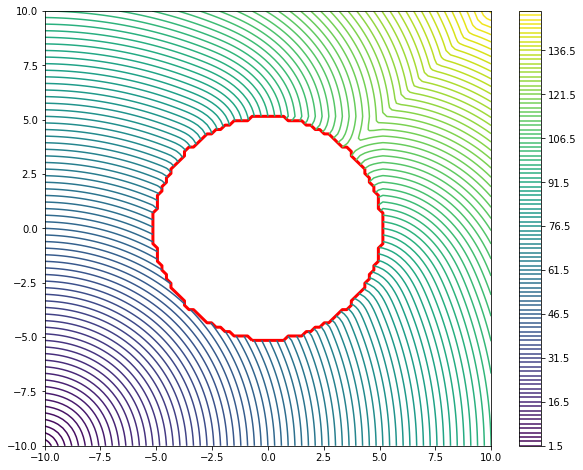

In [169]:
plt.figure(figsize=(10, 8))
plt.contour(X, Y, phi, [0], linewidths=(3), colors='black')
plt.contour(X, Y, phi.mask, [0], linewidths=(3), colors='red')
plt.contour(X, Y, distance.T, 100)
plt.colorbar()
plt.show()

In [170]:
def map_function(point, dx, dy):
    new_point = (int((point[0]+10)*10)-1, int((point[1]+10)*10)-1)
    gradx = dx[new_point]
    grady = dy[new_point]
    i = 0
    if gradx == 0 or grady == 0 :
        for i in range(-100, 100):
            for j in range(-100, 100):
                new_point = (int((point[0]+10)*10)+i, int((point[1]+10)*10)+j)
                gradx = dx[new_point]
                grady = dy[new_point]
                if (gradx != 0 and grady != 0):
                    return new_point
    return new_point 

In [171]:
gradient_vector = lambda x, y : np.array([gradient[0][x, y], gradient[1][x, y]])

In [172]:
def gradient_descent(alpha, iterations, distance, dx, dy, X, Y, start_point):
    path = [start_point]
    next_point_coordinate_approx = map_function(start_point, dx, dy)
    for i in range(iterations):
        gradx = dx[next_point_coordinate_approx[0], next_point_coordinate_approx[1]]
        grady = dy[next_point_coordinate_approx[0], next_point_coordinate_approx[1]]
        mod = np.sqrt(gradx**2 + grady**2)
        beta = np.arctan(grady/gradx)
        next_point = path[-1] - alpha * mod * np.array([np.cos(beta), np.sin(beta)])
        next_point_coordinate_approx = map_function(next_point, dx, dy)
        path.append(next_point)
        if next_point[0] <= -9.9 or next_point[1] <= -9.9:
            return path 
    return path

In [173]:
path = gradient_descent(0.0001, 1000000, distance, dx, dy, X, Y, [9.8, 9.9])

IndexError: index 197 is out of bounds for axis 0 with size 100

/Users/mathildebadoual/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


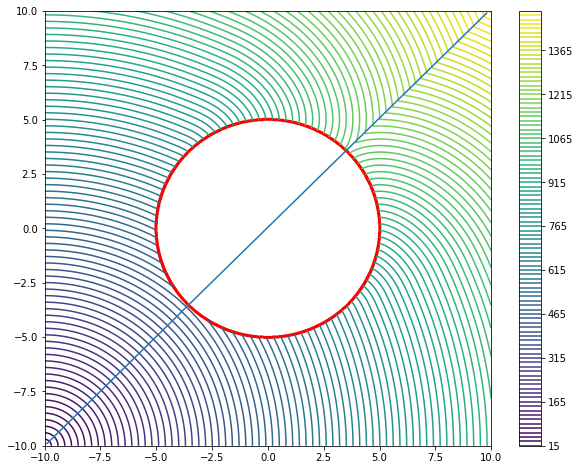

In [166]:
plt.figure(figsize=(10, 8))
plt.contour(X, Y, phi, [0], linewidths=(3), colors='black')
plt.contour(X, Y, phi.mask, [0], linewidths=(3), colors='red')
plt.contour(X, Y, distance.T, 100)
plt.colorbar()
plt.plot(*zip(*path))
plt.savefig('result1.png')
plt.show()

In [146]:
def compute_shortest_path_1(n):
    l = 20
    X, Y = np.meshgrid(np.linspace(-l/2, l/2, n), np.linspace(-l/2, l/2, n))
    phi = np.ones((n, n))
    phi[np.logical_and(X==-10, Y==-10)] = 0
    mask = np.less_equal(np.sqrt(3*X**2 + 1/2*Y**2), 5)
    phi = np.ma.MaskedArray(phi, mask)
    distance = skfmm.distance(phi)
    distance = distance.T
    start_time = time.time()
    path = gradient_descent(0.001, 1000000, distance, dx, dy, X, Y, [9.9, 9.9])
    end_time = time.time() - start_time
    return distance[-1, -1], end_time

In [147]:
print(compute_shortest_path_1(1000))

(1523.413904973307, 0.5185701847076416)


In [148]:
path_list = []
time_list = []
for n in range(2, 1000, 10):
    path, t = compute_shortest_path_1(n)
    path_list.append(path)
    time_list.append(t)

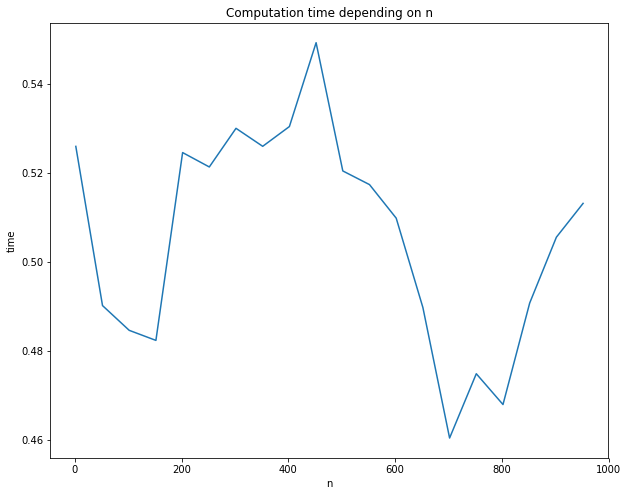

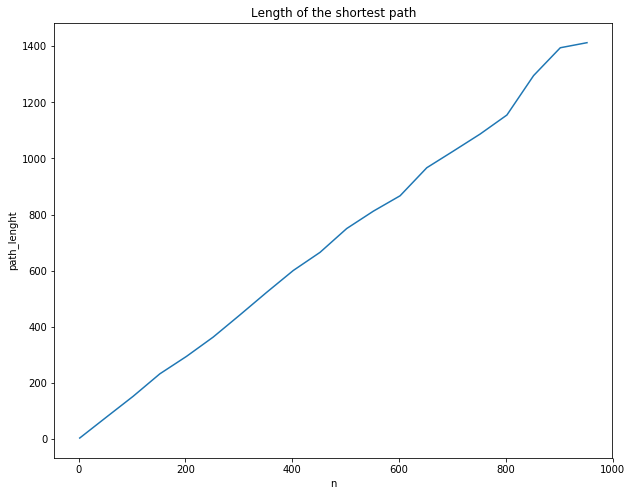

In [139]:
plt.figure(figsize=(10, 8))
plt.title('Computation time depending on n')
plt.xlabel('n')
plt.ylabel('time')
plt.plot(range(2, 1000, 50), time_list, label='time')

plt.figure(figsize=(10, 8))
plt.title('Length of the shortest path')
plt.xlabel('n')
plt.ylabel('path_lenght')
plt.plot(range(2, 1000, 50), path_list, label='path_lenght')

In [60]:
import urllib.request
import json

contents = urllib.request.urlopen("https://ce290-hw5-weather-report.appspot.com/?date=2018-03-30").read()
parsed_json = json.loads(contents)
centroid_y = parsed_json['centroid_y']
centroid_x = parsed_json['centroid_x']
radius = parsed_json['radius']
print(contents)

b'{"centroid_y":11,"centroid_x":11,"radius":6}'


In [154]:
def compute_shortest_path_2(centroid_y, centroid_x, radius, n):
    l = 20
    
    X, Y = np.meshgrid(np.linspace(-l/2, l/2, n), np.linspace(-l/2, l/2, n))
    
    phi = np.ones((n, n))
    phi[np.logical_and(X==-10, Y==-10)] = 0
    mask = np.less_equal(np.sqrt((X - (centroid_y - 10))**2 + (Y - (centroid_y - 10))**2), radius)
    phi = np.ma.MaskedArray(phi, mask)
    distance = skfmm.distance(phi)
    distance = distance.T
    
    start_time = time.time()
    
    #compute gradient with Sobel method
    dx = cv2.Sobel(distance,cv2.CV_64F, 0, 1, ksize=1)
    dy = cv2.Sobel(distance,cv2.CV_64F, 1, 0, ksize=1)
    
    path = gradient_descent(0.001, 1000000, distance, dx, dy, X, Y, [9.9, 10])
    
    end_time = time.time() - start_time
    
    #plot 
    plt.figure(figsize=(10, 8))
    plt.contour(X, Y, phi, [0], linewidths=(3), colors='black')
    plt.contour(X, Y, phi.mask, [0], linewidths=(3), colors='red')
    plt.contour(X, Y, distance.T, 100)
    plt.colorbar()
    plt.plot(*zip(*path))
    plt.title('figure'+str(n)+'.png')
    plt.savefig('')
    plt.show()
    
    return path, end_time

/Users/mathildebadoual/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


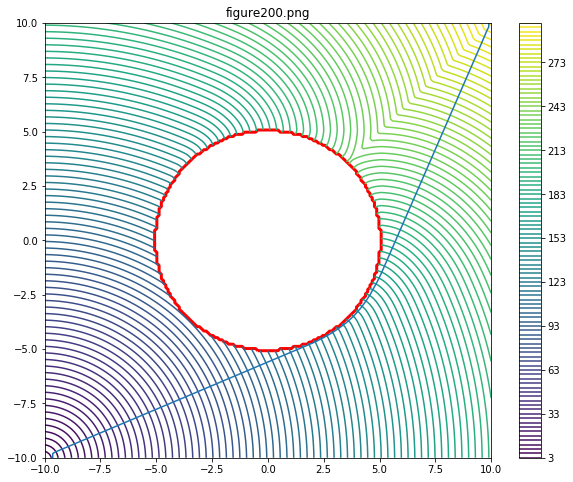

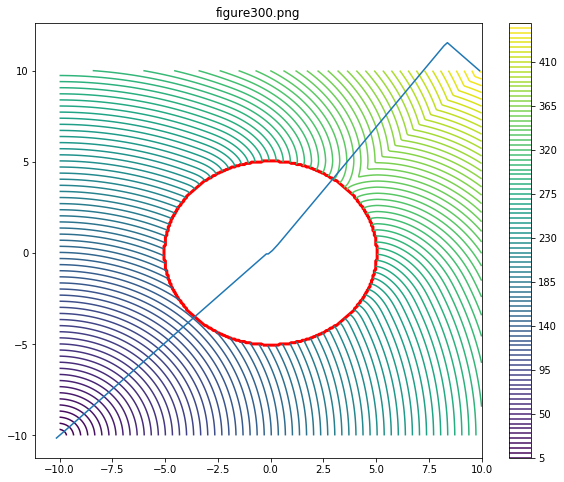

In [158]:
path, end_time = compute_shortest_path_2(10, 10, 5, 200)
path, end_time = compute_shortest_path_2(10, 10, 5, 300)

In [179]:
def index(date, n):
    start_time = time.time()
    
    input_json = requests.get('https://ce290-hw5-weather-report.appspot.com/?date='+date).json()
    input_x = input_json['centroid_x']
    input_y = input_json['centroid_y']
    input_r = input_json['radius']
    
    input_x = 10
    input_y = 10
    input_r = 5
    
    storm_x = input_x * n /20
    storm_y = input_y * n /20
    storm_r = input_r * n /20


    # Create phi, generated from the origin (following logic of example in https://pythonhosted.org/scikit-fmm/)
    phi_o = np.ones((n + 1, n + 1))
    phi_o[0][0] = 0

    # Open grid created of same size as phi, then circular mask created and applied to phi_o
    y, x = np.ogrid[0:n + 1, 0:n + 1]
    mask = (x - storm_x) ** 2 + (y - storm_y) ** 2 <= storm_r ** 2
    phi_masked_o = np.ma.MaskedArray(phi_o, mask)

    # Calculate the fast marching distance using phi_masked_o
    skfmm_dist_o = skfmm.distance(phi_masked_o)

    # The fast marching approach is done again, except with the "origin" placed at the true destination. This will return the
    # distance between the destination and all other points in the grid
    phi_d = np.ones((n + 1, n + 1))
    phi_d[n][n] = 0

    # Apply same mask from earlier onto new phi_d
    phi_masked_d = np.ma.MaskedArray(phi_d, mask)

    # Calculate the fast marching distance using phi_masked_d
    skfmm_dist_d = skfmm.distance(phi_masked_d)

    skfmm_dist_t = skfmm_dist_o + skfmm_dist_d
    path = np.zeros((2, (2 * n)))

    # Start counters k and j off at the constant s. Instead of changing s, iterate down on k and j until we've reached the origin
    # Steps available represents the total number of steps horizontal/vertical
    k = n
    j = n
    steps_available = (2 * n) - 1

    while (k != 0) & (j != 0):
        val_side = skfmm_dist_t[k - 1][j]
        val_below = skfmm_dist_t[k][j - 1]
        if (val_side < val_below):
            k = k - 1
            path[0][steps_available] = k
            path[1][steps_available] = j
        else:
            j = j - 1
            path[0][steps_available] = k
            path[1][steps_available] = j
        steps_available = steps_available - 1


    # Plot the shortest path onto the distance matrix total (combined origin and destination distances)
    path_x = path[1, :]
    path_y = path[0, :]
    end_time = time.time()
    plt.figure(figsize=(5, 5))
    cax = plt.imshow(skfmm_dist_t, cmap='viridis', origin='lower')
    plt.colorbar()
    
    plt.plot(path_x, path_y, color='red')
    
    red = (0, 0, 0)  # color of our text
    text_pos = (10, 10)  # top-left position of our text
    text = "date : "+str(date)+" n : "+str(n) + " response time : " + str(np.round((end_time-start_time)/60,3)) + " min"  # text to draw
    plt.title(text)
    plt.savefig(str(n)+'.png')
    
    return  text, str(np.round((end_time-start_time)/60,3)), skfmm_dist_t[-1, -1]  # and we're done!

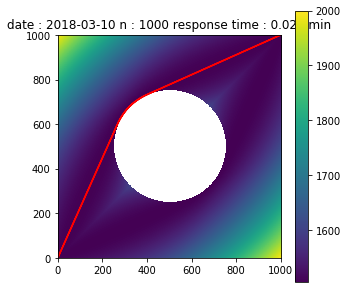

In [180]:
text, t, path = index('2018-03-10', 1000)

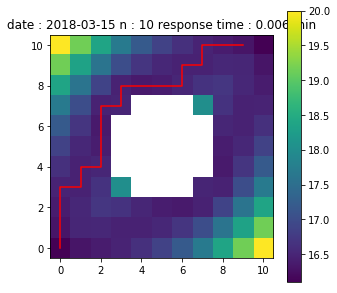

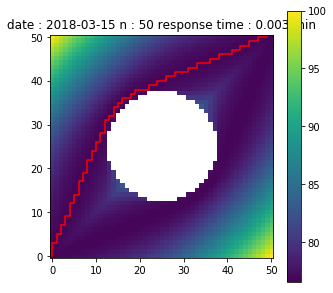

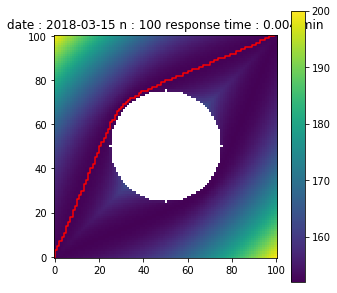

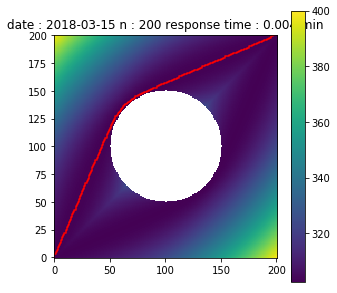

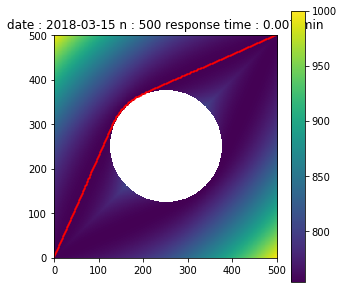

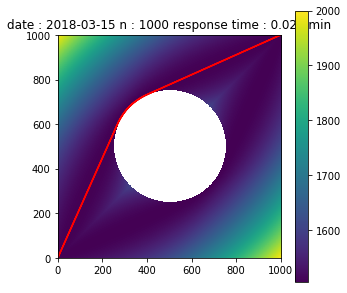

In [181]:
path_list = []
t_list = []
for n in [10, 50, 100, 200, 500, 1000]:
    text, t, path = index('2018-03-15', n)
    path_list.append(path)
    t_list.append(t)


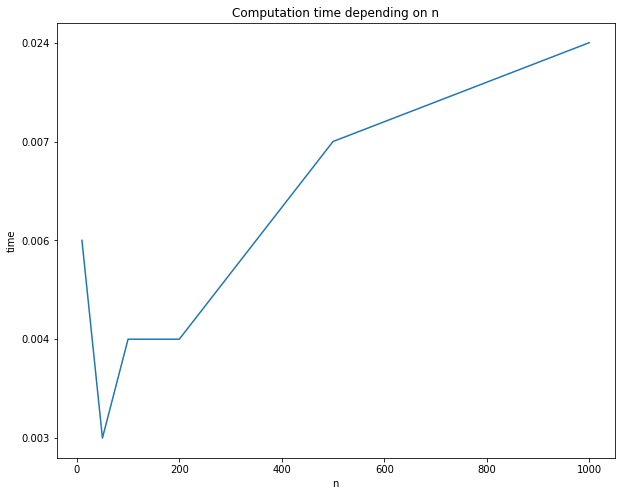

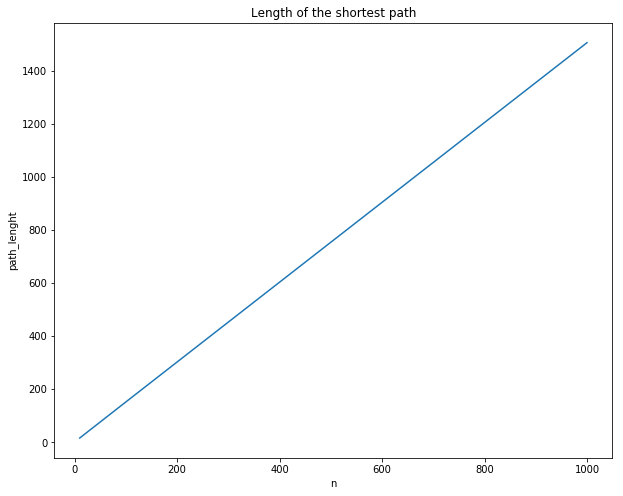

In [186]:
plt.figure(figsize=(10, 8))
plt.title('Computation time depending on n')
plt.xlabel('n')
plt.ylabel('time')
plt.plot([10, 50, 100, 200, 500, 1000], t_list, label='time')
plt.savefig('time.png')

plt.figure(figsize=(10, 8))
plt.title('Length of the shortest path')
plt.xlabel('n')
plt.ylabel('path_lenght')
plt.plot([10, 50, 100, 200, 500, 1000], path_list, label='path_lenght')
plt.savefig('length.png')